In [13]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import pickle

In [14]:
df = pd.read_csv("../data/processed/gladiador_data_procesado.csv")
df.head()

,Wins,Public Favor,Survived,Allegiance Network_Strong
0,11,0.841842,False,1
1,7,0.651044,True,0
2,6,0.593816,True,1
3,6,0.540815,False,1
4,12,0.761651,False,1


In [15]:
df['Survived'] = df['Survived'].astype(int)
df.head()

,Wins,Public Favor,Survived,Allegiance Network_Strong
0,11,0.841842,0,1
1,7,0.651044,1,0
2,6,0.593816,1,1
3,6,0.540815,0,1
4,12,0.761651,0,1


## MODELO BAGGING CLASSIFIER

In [16]:
X = df[["Wins", "Public Favor", "Allegiance Network_Strong"]]
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7980, 3)
(7980,)
(1996, 3)
(1996,)


In [6]:
estimator = DecisionTreeClassifier(max_depth=3, random_state=42)

bag_clf = BaggingClassifier(
    estimator = estimator,
    n_estimators=300, # Cantidad de modelos
    max_samples=100, # Muestras utilizadas en boostrapping
    bootstrap=True, # Usamos boostrapping
    max_features = 3, # Features que utiliza en el boostrapping. Cuanto más bajo, mejor generalizará y menos overfitting
    random_state=42)


bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7224448897795591

In [17]:
cv= KFold(10)
cv_bc = cross_val_score(estimator=estimator, X=X, y=y, cv=cv, scoring="accuracy")

In [31]:
print(cv_bc)

[0.72845691 0.72945892 0.72344689 0.74849699 0.72845691 0.72044088
 0.72116349 0.71614845 0.7111334  0.72417252]


In [32]:
print(cv_bc.max())

0.748496993987976


In [ ]:
print(cv_bc.mean())

0.7251375368590742


In [21]:
#Creo un DataFrame completo de entrenamiento combinando X_train y y_train
train_df = pd.concat([X_train, y_train], axis=1)

#Creo un DataFrame completo de prueba combinando X_test y y_test
test_df = pd.concat([X_test, y_test], axis=1)

# Guardar los DataFrames en archivos CSV
train_df.to_csv("../data/train/train_data.csv", index=False)
test_df.to_csv("../data/test/test_data.csv", index=False)

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
#Realizo Predicciones

# Predicciones sobre el mismo conjunto de datos de entrenamiento
pred_bag = bag_clf.predict(X_test)

In [29]:
#Obtengo las PROBABILIDADES de predicción
pred_proba = bag_clf.predict_proba(X_test)[:, 1]

In [30]:
with open("../models/bg_model.pkl", "wb") as f:
    pickle.dump(bag_clf, f)


--- Introducir valores para una nueva muestra ---
Por favor, introduce los valores para la nueva muestra:


C:\Users\yoai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(
C:\Users\yoai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(



--- Resultado de la Predicción Manual ---
Predicción: El individuo **NO SOBREVIVIRÁ** (Clase 0).
Probabilidad de Sobrevivir: 0.0472


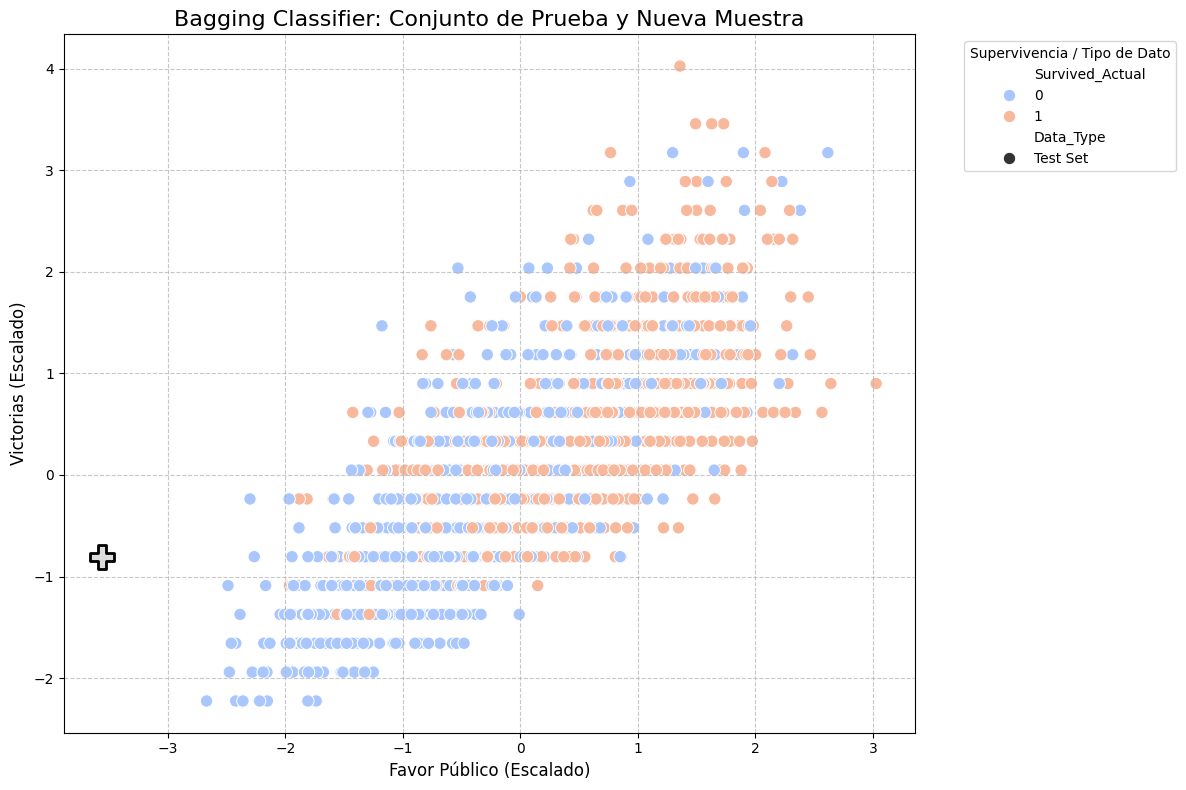

In [27]:
#Predicción con valores introducidos manualmente
print("\n--- Introducir valores para una nueva muestra ---")
print("Por favor, introduce los valores para la nueva muestra:")

try:
    wins_input = float(input("Victorias (Wins, ej. 10): "))
    public_favor_input = float(input("Favor Público (Public Favor, ej. 0.75, entre 0 y 1): "))
    allegiance_network_strong_input = float(input("Fuerza de Red de Lealtad (Allegiance Network_Strong, ej. 0 o 1): "))

    new_data_manual = pd.DataFrame([[wins_input, public_favor_input, allegiance_network_strong_input]],
                                   columns=['Wins', 'Public Favor', 'Allegiance Network_Strong'])

    new_data_manual_scaled = scaler.transform(new_data_manual)
    predicted_survival = bag_clf.predict(new_data_manual_scaled)
    predicted_proba =bag_clf.predict_proba(new_data_manual_scaled)[0]

    print("\n--- Resultado de la Predicción Manual ---")
    if predicted_survival[0] == 1:
        print(f"Predicción: ¡El individuo **SOBREVIVIRÁ** (Clase 1)!")
    else:
        print(f"Predicción: El individuo **NO SOBREVIVIRÁ** (Clase 0).")
    print(f"Probabilidad de Sobrevivir: {predicted_proba[1]:.4f}")

    #Visualización
    #Convierto X_test_scaled de nuevo a DataFrame para facilitar la graficación con Seaborn
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)
    X_test_scaled_df['Survived_Actual'] = y_test.values
    X_test_scaled_df['Data_Type'] = 'Test Set' #Etiqueta para el conjunto de prueba

    #Uso los valores ESCALADOS para que estén en el mismo rango que X_test_scaled_df
    new_manual_point_df = pd.DataFrame(new_data_manual_scaled, columns=X.columns)
    new_manual_point_df['Survived_Actual'] = predicted_survival[0] #Uso la predicción como su "actual" para el color
    new_manual_point_df['Data_Type'] = 'Nueva Muestra Manual' #Etiqueta para el punto manual


    #Concateno ambos DataFrames para graficar juntos
    #Sólo incluyo las columnas relevantes para el gráfico, en este ejemplo, uso 'Public Favor' y 'Wins'.
    plot_df = pd.concat([
        X_test_scaled_df[['Public Favor', 'Wins', 'Survived_Actual', 'Data_Type']],
        new_manual_point_df[['Public Favor', 'Wins', 'Survived_Actual', 'Data_Type']]
    ])
    #Aseguro que la columna de la clase sea int para el coloreado
    plot_df['Survived_Actual'] = plot_df['Survived_Actual'].astype(int)


    #Genero el Scatterplot con el Punto Manual
    plt.figure(figsize=(12, 8))

    sns.scatterplot(
        x='Public Favor',
        y='Wins',
        hue='Survived_Actual', #Color según la clase real
        style='Data_Type',     #Estilo para diferenciar Test Set y Nueva Muestra
        markers={'Test Set': 'o', 'Nueva Muestra Manual': 'P'}, # 'o' para test, 'P' para el punto manual
        s=80,                  #Tamaño para los puntos del set de prueba
        palette='coolwarm', 
        data=plot_df[plot_df['Data_Type'] == 'Test Set'], #Solo los datos de prueba
        legend='full'
    )

    #Superponer el punto de datos manual
    sns.scatterplot(
        x='Public Favor',
        y='Wins',
        hue='Survived_Actual', #Color según la predicción de la nueva muestra
        style='Data_Type',
        markers={'Test Set': 'o', 'Nueva Muestra Manual': 'P'},
        s=300,                 #Tamaño más grande para el punto manual
        edgecolor='black',     #Borde negro para resaltarlo
        linewidth=2,
        palette='coolwarm',
        data=plot_df[plot_df['Data_Type'] == 'Nueva Muestra Manual'], #Solo el punto manual
        legend=False # No duplicar la leyenda
    )


    plt.title('Bagging Classifier: Conjunto de Prueba y Nueva Muestra', fontsize=16)
    plt.xlabel('Favor Público (Escalado)', fontsize=12)
    plt.ylabel('Victorias (Escalado)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Supervivencia / Tipo de Dato', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

except ValueError:
    print("\nEntrada inválida. Asegúrate de introducir números para los valores.")
except KeyError as e:
    print(f"\nError de columna: {e}. Asegúrate de que las columnas 'Wins', 'Public Favor' y 'Allegiance Network_Strong' existan en tu DataFrame original y que las estés nombrando correctamente.")
except Exception as e:
    print(f"\nOcurrió un error general: {e}")